# UNet semantic segmentation on PASCAL_VOC_2007

In [1]:
import cv2
import math
import glob
import inspect
import json
import mlflow
import torch
import os
import time
import sys
import datasets

import torchvision as tv
import lightning as L
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pytorch_lightning.loggers import MLFlowLogger
from lightning.pytorch.callbacks import ModelCheckpoint

/home/henning/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/henning/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [45]:
class CustomDataset(Dataset):
    def __init__(self, root, train=True):
        self.root = root

        splits = ["train", "test", "validation"]
        dataset = []
        for split in splits:
            dataset_ = datasets.load_dataset("fuliucansheng/pascal_voc", "voc2007_main", split=split)
            dataset.extend(np.asarray(dataset_).tolist())
        self.elements = np.asarray(dataset)
        
        np.random.shuffle(self.elements)

        self.colors = np.random.randint(0, 256, (N_CLASSES, 3))
        self.colors[0] = 0, 0, 0

        n_train = int(len(self) * 0.8)
        if train:
            self.elements = self.elements[:n_train]
        else:
            self.elements = self.elements[n_train:]

    def __len__(self):
        return len(self.elements)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()

        element = self.elements[idx]

        p = 256
        S = np.random.randint(p + 1, 500)
        H = 500
        W = 500
    
        classes = element["classes"]
        objects = element["objects"]
        bboxes = objects["bboxes"]
        bboxes_classes = objects["classes"]

        indices = np.arange(0, len(bboxes))
        np.random.shuffle(indices)

        bboxes = np.asarray(bboxes)
        bboxes_classes = np.asarray(bboxes_classes)
        
        bboxes = bboxes[indices]
        bboxes_classes = bboxes_classes[indices]
        
        img = element["image"]
        img = np.asarray(img)
        h, w, c = img.shape
    
        padded_img = np.zeros([H, W, 3], dtype=np.uint8)
        mask = np.zeros([H, W], dtype=np.uint8)
        mask_rgb = np.zeros([H, W, 3], dtype=np.uint8)
        
        offset_x = W - w
        offset_y = H - h
    
        padded_img[offset_y:, offset_x:] = img
    
        scale_h = S / H
        scale_w = S / W
    
        padded_img = cv2.resize(padded_img, None, fx=scale_w, fy=scale_h)
        mask = cv2.resize(mask, None, fx=scale_w, fy=scale_h)

        coords = torch.zeros([10, 4])
        for j in range(len(classes)):
            x1, y1, x2, y2 = np.asarray(bboxes[j], dtype=int)
    
            x1 = int((x1 + offset_x) * scale_w)
            y1 = int((y1 + offset_y) * scale_h)
            x2 = int((x2 + offset_x) * scale_w)
            y2 = int((y2 + offset_y) * scale_h)
    
            mask[y1:y2, x1:x2] = bboxes_classes[j]
            coords[j] = torch.tensor([x1, y1, x2, y2])

        img = padded_img.copy()
        mask = mask.copy()

        H, W, c = img.shape

        rx = np.random.randint(0, W - p)
        ry = np.random.randint(0, H - p)

        img = img[ry:ry + p, rx:rx + p]
        mask = mask[ry:ry + p, rx:rx + p]

        coords[:, 0] = coords[:, 0] - rx
        coords[:, 1] = coords[:, 1] - ry
        coords[:, 2] = coords[:, 2] - rx
        coords[:, 3] = coords[:, 3] - ry
        
        img = torch.from_numpy(img).permute(2, 0, 1).to(torch.float32) / 255
        mask = torch.from_numpy(mask).to(torch.long)[None, :]
        
        sample = dict()
        sample["img"] = img
        sample["mask"] = mask
        sample["coords"] = coords

        return sample

In [41]:
ROOT_PATH = "../data"
BATCH_SIZE = 48
NUM_WORKERS = 4
DEVICE = "cuda"
LR = 5e-3
N_CLASSES = 20
N_EPOCHS = 1000
MODEL_IDENTIFIER = "unet"

In [46]:
train_dataset = CustomDataset(ROOT_PATH, train=True)
test_dataset = CustomDataset(ROOT_PATH, train=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False, num_workers=NUM_WORKERS)
print("Train:", len(train_dataset))
print("Test:", len(test_dataset))

Train: 7970
Test: 1993


In [47]:
element = next(iter(train_loader))

img = element["img"]
mask = element["mask"]
coords = element["coords"]

print("img", img.shape, img.min(), img.max())
print("mask", mask.shape, mask.min(), mask.max())
print("coords", coords.shape, coords.min(), coords.max())

img torch.Size([48, 3, 256, 256]) tensor(0.) tensor(1.)
mask torch.Size([48, 1, 256, 256]) tensor(0) tensor(19)
coords torch.Size([48, 10, 4]) tensor(-195.) tensor(454.)


In [6]:
@torch.no_grad
def test_model_config():
    batch = next(iter(train_loader))
    
    img = batch["img"].to(DEVICE)
    mask = batch["mask"].to(DEVICE)

    print(f"input")
    print(f"  {img.shape}")
        
    pred = model.test_model_config(img)
    
    print(f"output")
    print(f"  {pred.shape}")
    print(f"  {mask.shape}")
    print()
    
    pred = pred.permute(0, 2, 3, 1)
    pred = pred.reshape(-1, N_CLASSES)

    mask = mask.reshape(-1)
    
    loss = F.cross_entropy(pred, mask)
    print(loss)
def train():
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-6)
    for n_epoch in range(N_EPOCHS):
        sum_loss = 0
        count = 0
        for i, batch in enumerate(train_loader):
            img = batch["img"].to(DEVICE)
            mask = batch["mask"].to(DEVICE)

            pred = model(img)

            pred = pred.permute(0, 2, 3, 1)
            pred = pred.reshape(-1, N_CLASSES)
        
            mask = mask.reshape(-1)
            
            loss = F.cross_entropy(pred, mask)
            loss.backward()

            sum_loss += loss.item()
            count += 1

            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            print(f"\r{n_epoch + 1}|{N_EPOCHS}, {i + 1}|{len(train_loader)}, loss: {sum_loss / count}", end="")
        print()
def show_batch(loader, inference=False, n=2, m=4):
    element = next(iter(loader))
    
    img = element["img"]
    mask = element["mask"]
    coords = element["coords"]

    if inference:
        with torch.no_grad():
            model.to(DEVICE)
            model.eval()
            img = img.to(DEVICE)
            pred = model(img)
            pred = pred.permute(0, 2, 3, 1).detach().cpu().numpy().argmax(axis=-1)
    
    img = np.asarray(img.permute(0, 2, 3, 1).detach().cpu().numpy() * 255, dtype=np.uint8)
    mask = mask.permute(0, 2, 3, 1).detach().cpu().numpy()
    coords = coords.to(torch.int).detach().cpu().numpy()
    
    result_column = []
    for i in range(n):
        result_row = []
        for j in range(m):
            idx = (i * m) + j
            
            img_ = img[idx]
            mask_ = mask[idx]
            coords_ = coords[idx]
    
            for xl, yl, xu, yu in coords_:
                img_ = cv2.rectangle(img_.copy(), (xl, yl), (xu, yu), (255, 0, 0), 2)
        
            mask_rgb = np.repeat(mask_, 3, -1)
            mask_ = mask_[:, :, 0]
            for k in range(N_CLASSES):
                indices = mask_ == k
                mask_rgb[indices] = train_dataset.colors[k]

            if inference:
                pred_ = pred[idx]
                pred_rgb = np.repeat(pred_[:, :, None], 3, -1)
                for k in range(N_CLASSES):
                    indices = pred_ == k
                    pred_rgb[indices] = train_dataset.colors[k]
                result = np.concatenate([img_, mask_rgb, pred_rgb], axis=1)
            else:
                result = np.concatenate([img_, mask_rgb], axis=1)
                
            result_row.append(result)
        result_row = np.concatenate(result_row, axis=1)
        result_column.append(result_row)
    result = np.concatenate(result_column, axis=0)
            
    fig, axes = plt.subplots(1, 1, figsize=(20, 10))
    axes.imshow(result)
    plt.show()

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
class UNet(L.LightningModule):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.dropout = nn.Dropout(p=0.05)

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

        for p in self.parameters():
            torch.nn.init.normal_(p, mean=0.0, std=0.02)

    def forward(self, x):
        x1 = self.inc(x)
        x1 = self.dropout(x1)
        x2 = self.down1(x1)
        x2 = self.dropout(x2)
        x3 = self.down2(x2)
        x3 = self.dropout(x3)
        x4 = self.down3(x3)
        x4 = self.dropout(x4)
        x5 = self.down4(x4)
        x5 = self.dropout(x5)
        x = self.up1(x5, x4)
        x = self.dropout(x)
        x = self.up2(x, x3)
        x = self.dropout(x)
        x = self.up3(x, x2)
        x = self.dropout(x)
        x = self.up4(x, x1)
        x = self.dropout(x)
        logits = self.outc(x)
        return logits
        
    def test_model_config(self, x):
        print()
        print("============")
        print(x.shape)
        x1 = self.inc(x)
        print(x1.shape)
        x2 = self.down1(x1)
        print(x2.shape)
        x3 = self.down2(x2)
        print(x3.shape)
        x4 = self.down3(x3)
        print(x4.shape)
        x5 = self.down4(x4)
        print(x5.shape, x4.shape)
        x = self.up1(x5, x4)
        print(x.shape, x3.shape)
        x = self.up2(x, x3)
        print(x.shape, x2.shape)
        x = self.up3(x, x2)
        print(x.shape, x1.shape)
        x = self.up4(x, x1)
        print(x.shape)
        logits = self.outc(x)
        print(logits.shape)
        print("============")
        print()
        return logits
        
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=LR, weight_decay=1e-6)
        return optimizer

    def training_step(self, batch, batch_idx):

        img = batch["img"].to(DEVICE)
        mask = batch["mask"].to(DEVICE)
            
        pred = model(img)
        
        pred = pred.permute(0, 2, 3, 1)
        pred = pred.reshape(-1, N_CLASSES)
    
        mask = mask.reshape(-1)
        
        loss = F.cross_entropy(pred, mask)
        
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        
        return loss

    def validation_step(self, batch, batch_idx):

        img = batch["img"].to(DEVICE)
        mask = batch["mask"].to(DEVICE)
            
        pred = model(img)
        
        pred = pred.permute(0, 2, 3, 1)
        pred = pred.reshape(-1, N_CLASSES)
    
        mask = mask.reshape(-1)
        
        loss = F.cross_entropy(pred, mask)
        
        self.log("val_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        
        return loss

    def on_train_epoch_end(self):
        print()

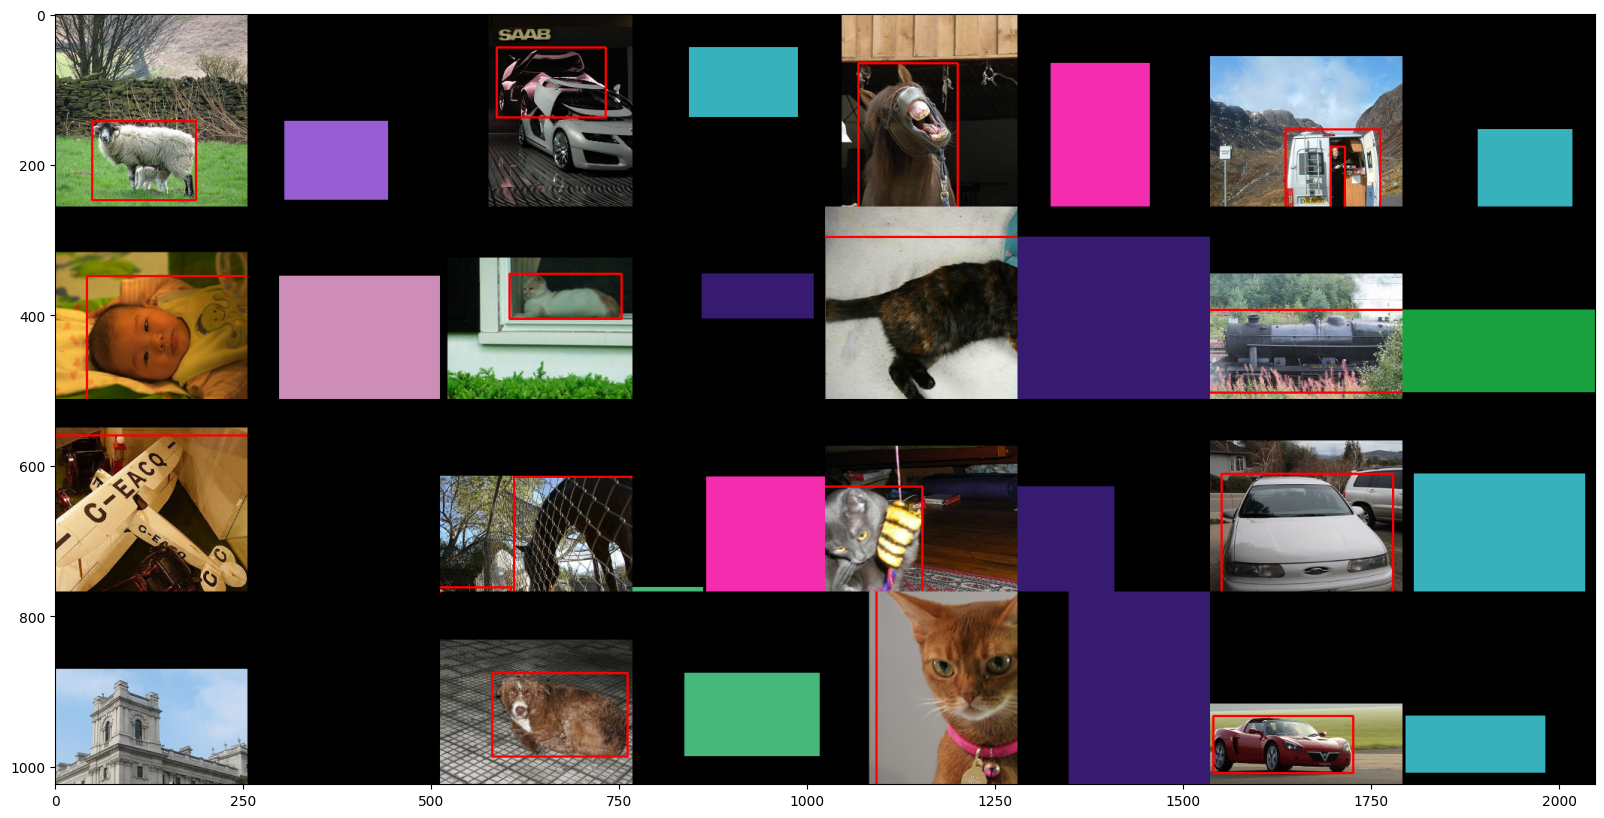

In [48]:
show_batch(train_loader, inference=False, n=4, m=4)

In [10]:
# model = UNet(n_channels=3, n_classes=N_CLASSES).to(DEVICE)
model = UNet.load_from_checkpoint("283429787060125271/13db8fe3fb6d4e4cbced8c1b477322ef/checkpoints/epoch=820-step=137452.ckpt")

In [11]:
test_model_config()

input
  torch.Size([48, 3, 256, 256])

torch.Size([48, 3, 256, 256])
torch.Size([48, 64, 256, 256])
torch.Size([48, 128, 128, 128])
torch.Size([48, 256, 64, 64])
torch.Size([48, 512, 32, 32])
torch.Size([48, 1024, 16, 16]) torch.Size([48, 512, 32, 32])
torch.Size([48, 512, 32, 32]) torch.Size([48, 256, 64, 64])
torch.Size([48, 256, 64, 64]) torch.Size([48, 128, 128, 128])
torch.Size([48, 128, 128, 128]) torch.Size([48, 64, 256, 256])
torch.Size([48, 64, 256, 256])
torch.Size([48, 20, 256, 256])

output
  torch.Size([48, 20, 256, 256])
  torch.Size([48, 1, 256, 256])

tensor(3.0117, device='cuda:0')


In [12]:
mlflow_logger = MLFlowLogger(
    experiment_name="default",
    tracking_uri="http://localhost:8888"
)

trainer = L.Trainer(devices=1, 
                    accelerator="gpu",
                    max_epochs=N_EPOCHS,
                    enable_checkpointing=True,
                    benchmark=True,
                    accumulate_grad_batches=1,
                    logger=mlflow_logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=test_loader)

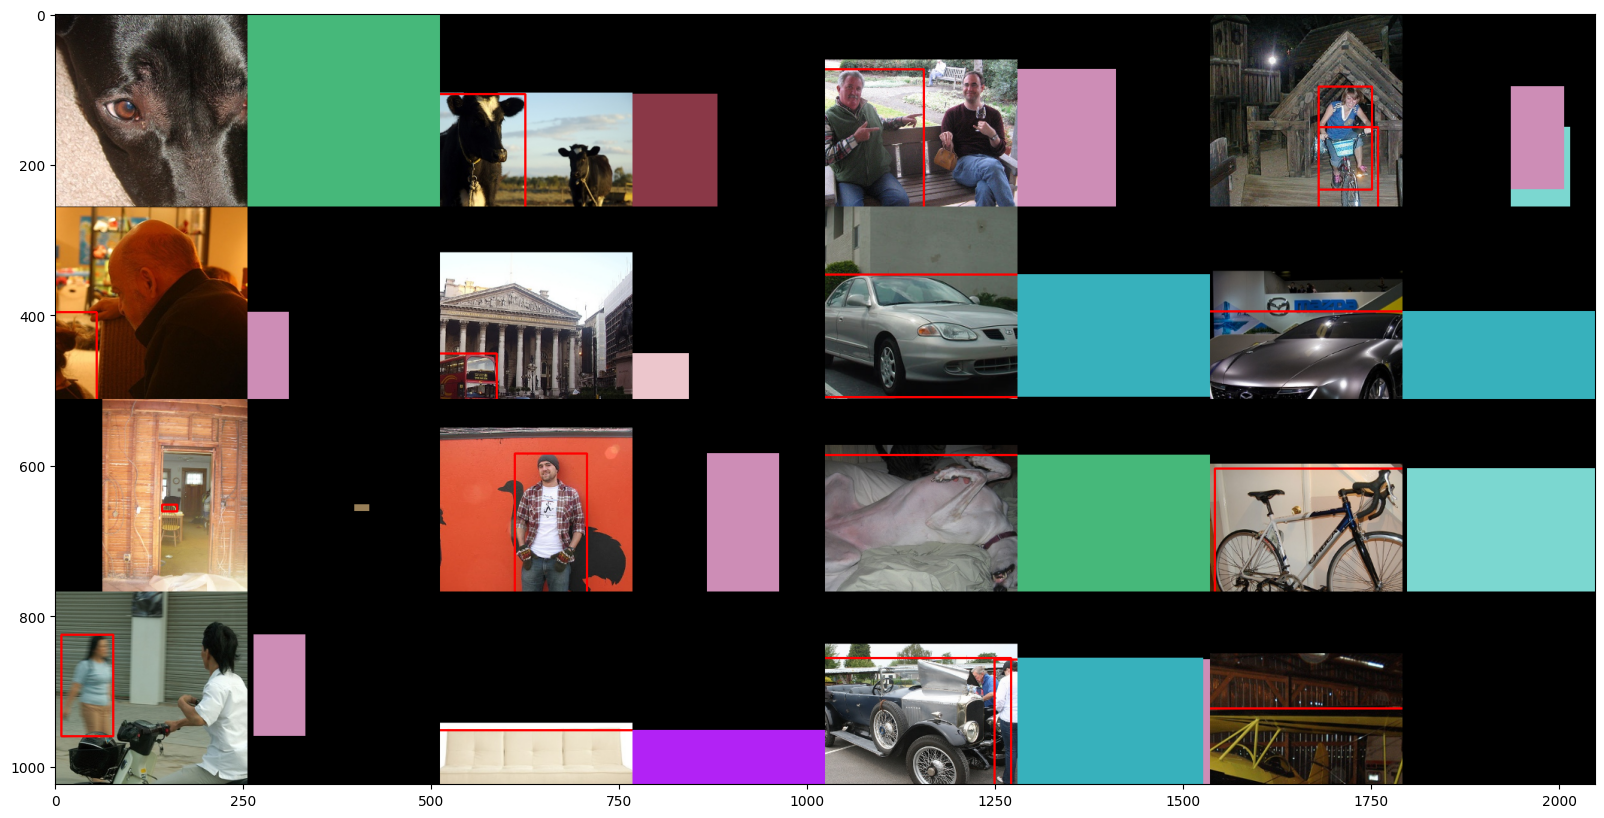

In [58]:
show_batch(train_loader, inference=False, n=4, m=4)

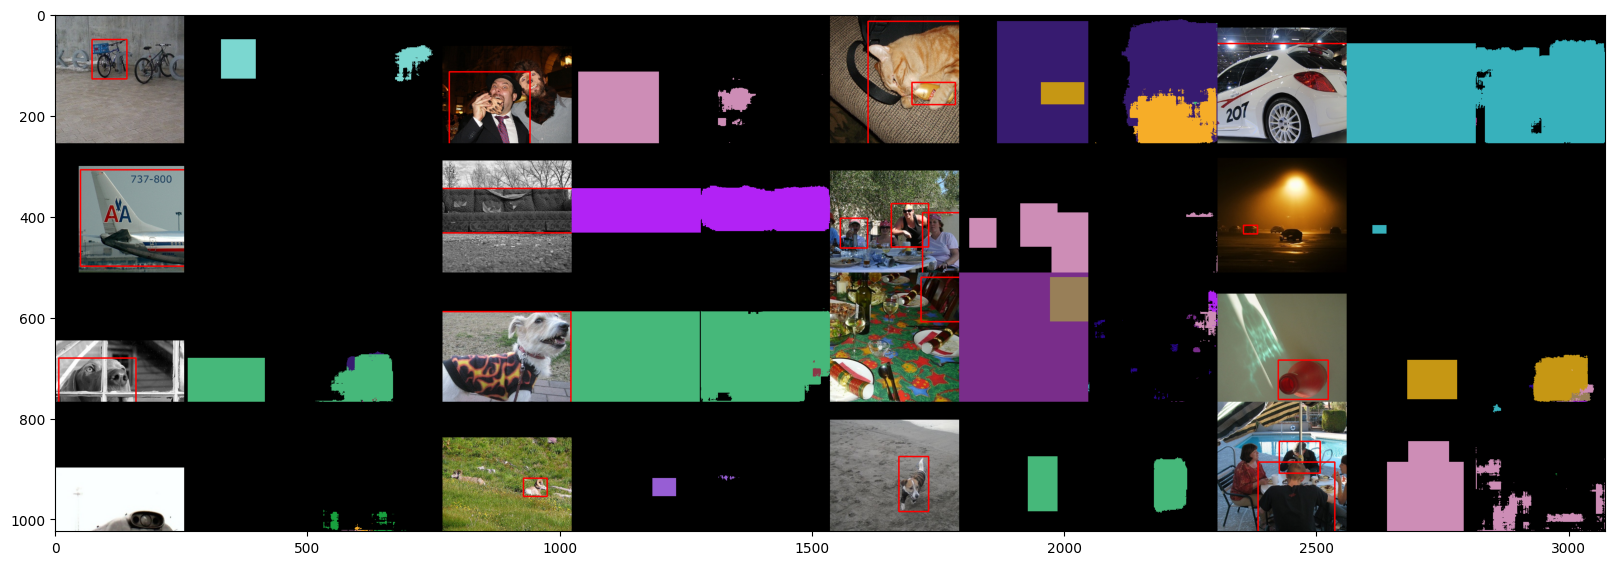

In [59]:
show_batch(train_loader, inference=True, n=4, m=4)

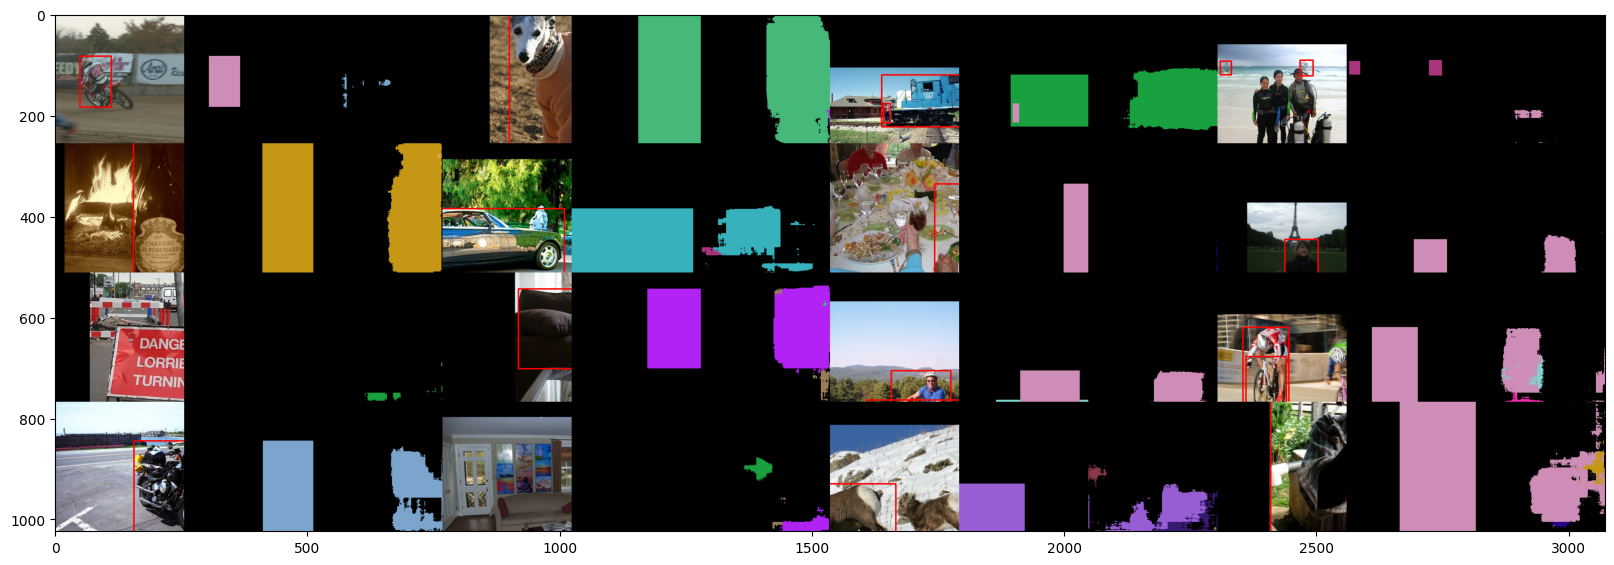

In [60]:
show_batch(test_loader, inference=True, n=4, m=4)